2017

Machine Learning Practical

University of Edinburgh

Georgios Pligoropoulos - s1687568

Coursework 4 (part 2)

### Imports, Inits, and helper functions

In [1]:
from __future__ import division

In [4]:
jupyterNotebookEnabled = True
plotting = True

if jupyterNotebookEnabled:
    %matplotlib inline

In [2]:
if jupyterNotebookEnabled:
    %load_ext autoreload
    %autoreload 2

In [3]:
import sys, os
mlpdir = os.path.expanduser(
    '~/pligor.george@gmail.com/msc_Artificial_Intelligence/mlp_Machine_Learning_Practical/mlpractical'
)
sys.path.append(mlpdir)

In [5]:
coursework, part = 4, 2
saving = True

In [6]:
import pickle
import skopt
from skopt.plots import plot_convergence
from mylibs.jupyter_notebook_helper import show_graph
import datetime
import time
import tensorflow as tf
import numpy as np
from mlp.data_providers import MSD10GenreDataProvider, MSD25GenreDataProvider,\
    MSD10Genre_Autoencoder_DataProvider, MSD10Genre_StackedAutoEncoderDataProvider
import matplotlib.pyplot as plt
from mylibs.batch_norm import fully_connected_layer_with_batch_norm_and_l2
from mylibs.stacked_autoencoder_pretrainer import \
    constructModelFromPretrainedByAutoEncoderStack,\
    buildGraphOfStackedAutoencoder, executeNonLinearAutoencoder
    
from mylibs.jupyter_notebook_helper import getRunTime, getTrainWriter, getValidWriter,\
    plotStats, initStats, gatherStats
    
from mylibs.tf_helper import tfRMSE, tfMSE,validateEpoch, trainEpoch,\
    fully_connected_layer

from mylibs.py_helper import merge_dicts, factors

from mylibs.batch_norm import batchNormWrapper_byExponentialMovingAvg,\
    fully_connected_layer_with_batch_norm

from collections import OrderedDict
    
from mylibs.dropout_helper import constructProbs

from skopt.space.space import Real, Integer, Categorical
from skopt import gp_minimize
from mylibs.jupyter_notebook_helper import DynStats
import operator
from curriculum_learning.msd10_data_providers import MSD10Genre_CurriculumLearning

In [7]:
seed = 16011984
rng = np.random.RandomState(seed=seed)

config = tf.ConfigProto(log_device_placement=True, allow_soft_placement=True)
config.gpu_options.allow_growth = True

figcount = 0

tensorboardLogdir = 'tf_cw%d_%d' % (coursework, part)

curDtype = tf.float32

reluBias = 0.1

batch_size = 50

total_songs = 40000

### Load Pretrained model variables

In [8]:
hidden_dims = np.array([500, 500, 25, 10]).astype(int)
hidden_dims

array([500, 500,  25,  10])

In [9]:
pretrainedModelVarsFilename = 'pretrainedModelVars_base_model_cw4.npz'
modelVars = np.load(pretrainedModelVarsFilename)
modelVars = modelVars[modelVars.keys()[0]]

### MSD 10 genre task

In [10]:
best_probs_base_classifier_filename = 'best_probs_base_classifier.npy'
best_probs_base_classifier = np.load(best_probs_base_classifier_filename)

In [11]:
cross_entropies_filename = 'cross_entropies_base_classifier.npy'
cross_entropies = np.load(cross_entropies_filename)

In [12]:
# for i in range(200):
#     for a, b in train_data:
#         print a.shape, b.shape
#         print
# train_data = MSD10Genre_CurriculumLearning(cross_entropies,
#                                             which_set = 'train',
#                                             batch_size=batch_size,
#                                             curriculum_step=3,
#                                             repetitions = 2,
#                                             repeat_school_class = False)

In [13]:
def getCurriculumLearningDataProviders(cross_entropies, curriculum_step,
                                       repetitions, seed=seed, rng=rng, repeat_school_class = True,
                                      shuffle_cur_curriculum = False, reverse_order = False,
                                       enable_auto_level_incr = True):
    train_data = MSD10Genre_CurriculumLearning(cross_entropies,
                                                which_set = 'train',
                                                batch_size=batch_size,
                                                curriculum_step=curriculum_step,
                                                repetitions = repetitions,
                                                repeat_school_class = repeat_school_class,
                                                shuffle_cur_curriculum=shuffle_cur_curriculum,
                                                reverse_order = reverse_order,
                                                enable_auto_level_incr = enable_auto_level_incr)

    #rng = np.random.RandomState(seed=seed)
    valid_data = MSD10GenreDataProvider('valid', batch_size=batch_size, rng=rng)
    
    return train_data, valid_data

In [14]:
defaultLearningRate = 1e-4
defaultLamda2 = 1e-2

In [15]:
#tf.reset_default_graph() #kind of redundant statement

def getGraph(train_data,
             learningRate = defaultLearningRate, #default of Adam is 1e-3
             lamda2 = defaultLamda2,
             momentum = 0.5, isPretrained = True, verbose=True):
    
    if verbose:
        print "l2 regularization factor: {}".format(lamda2)
        print "Adam learning rate: {}".format(learningRate)

    graph = tf.Graph() #create new graph

    hidden_layers = []
    regularizers = []
    keep_probs = []

    with graph.as_default():
        with tf.name_scope('data'):
            inputs = tf.placeholder(curDtype, [batch_size, train_data.inputs.shape[1]],
                                    name = 'inputs')
            targets = tf.placeholder(curDtype, [batch_size, train_data.num_classes],
                                     name = 'targets')

        with tf.name_scope('params'):
            training = tf.placeholder(tf.bool, name="training")

        with tf.name_scope("dropout0"):
            keep_probs.append(tf.placeholder(tf.float32))
            inputs_prob = tf.nn.dropout(inputs, keep_probs[0])

        with tf.name_scope('fullyConnected0'):
            curLayer, curRegularizer = fully_connected_layer_with_batch_norm_and_l2(
                0, inputs_prob,
                train_data.inputs.shape[1], hidden_dims[0],
                nonlinearity= tf.nn.tanh,
                w = modelVars[0][0] if isPretrained else None,
                b = modelVars[0][1] if isPretrained else None,
                training=training,
                lamda2 = lamda2
            )

            hidden_layers.append(curLayer)
            regularizers.append(curRegularizer)


        for i in range(1, len(hidden_dims)-1):
            with tf.name_scope("dropout%d" % i):
                keep_probs.append(tf.placeholder(tf.float32))
                cur_hidden_layer_prob = tf.nn.dropout(hidden_layers[i-1], keep_probs[i])

            with tf.name_scope('fullyConnected%d' % i):
                curLayer, curRegularizer = fully_connected_layer_with_batch_norm_and_l2(i,
                                      cur_hidden_layer_prob,
                                      hidden_dims[i-1], hidden_dims[i],
                                      nonlinearity = tf.nn.tanh,
                                      w = modelVars[i][0] if isPretrained else None,
                                      b = modelVars[i][1] if isPretrained else None,
                                      training = training,
                                      lamda2 = lamda2)

                hidden_layers.append(curLayer)
                regularizers.append(curRegularizer)


        finalIndex = len(hidden_dims)-1

        with tf.name_scope("dropout%d" % finalIndex):
            keep_probs.append(tf.placeholder(tf.float32))
            final_hidden_layer_prob = tf.nn.dropout(hidden_layers[finalIndex-1],
                                                    keep_probs[finalIndex])

        with tf.name_scope('readout_output_layer'):
            outputs, curRegularizer = fully_connected_layer_with_batch_norm_and_l2(finalIndex,
                final_hidden_layer_prob,
                hidden_dims[finalIndex-1], train_data.num_classes,
                training=training,
                nonlinearity=tf.identity,
                w = modelVars[finalIndex][0] if isPretrained else None,
                b = modelVars[finalIndex][1] if isPretrained else None,
                lamda2 = lamda2
            )

            regularizers.append(curRegularizer)

        with tf.name_scope('error'):
            #smaller cross entropy is better
            cross_entropy = tf.nn.softmax_cross_entropy_with_logits(outputs, targets) #(50, )
            error = tf.reduce_mean(cross_entropy) #() <-- scalar value

            for reg in regularizers:
                error += reg

        with tf.name_scope('accuracy'):
            accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(outputs, 1),
                                                       tf.argmax(targets, 1)),
                                                       dtype=curDtype))

        with tf.name_scope('train'):
            train_step = tf.train.AdamOptimizer(learning_rate=learningRate).minimize(error)
            #         train_step = tf.train.RMSPropOptimizer(
            #             learning_rate=learningRate,
            #             momentum=momentum
            #         ).minimize(error)

        init = tf.global_variables_initializer()

    return graph, init, error, accuracy, inputs, targets, training, keep_probs, train_step

In [16]:
def renderGraph():
    train_data, valid_data = getCurriculumLearningDataProviders(
        cross_entropies, curriculum_step=8, repetitions=3)
    #without pretraining. it crashes otherwise    
    show_graph(getGraph(train_data, isPretrained=False)[0])
    
renderGraph()

l2 regularization factor: 0.01
Adam learning rate: 0.0001


In [17]:
def trainAndValidate(graph, init, error, accuracy, inputs, targets, training, keep_probs,
                     train_step, input_keep_prob, hidden_keep_prob, train_data, valid_data,
                     epochs=35, verbose=True):
    
    if verbose:
        print "epochs: %d" % epochs
        print "input_keep_prob: %f" % input_keep_prob
        print "hidden_keep_prob: %f" % hidden_keep_prob
    
    keep_prob_dict = constructProbs(keep_probs,
                                    cur_input_prob=input_keep_prob,
                                    cur_hidden_prob=hidden_keep_prob)

    with tf.Session(graph=graph, config=config) as sess:
        sess.run(init)

        stats, keys = initStats(epochs)

        for e in range(epochs):
            (train_error, train_accuracy), runTime = getRunTime(lambda : 
                    trainEpoch(
                        inputs, targets, sess, train_data, train_step, error, accuracy,
                        extraFeedDict = merge_dicts(keep_prob_dict, {training: True})
                )
            )

            #print 'End epoch %02d (%.3f secs): err(train)=%.2f acc(train)=%.2f' % (e+1, runTime, train_error,train_accuracy)

            if (e + 1) % 1 == 0:
                valid_error, valid_accuracy = validateEpoch(
                    inputs, targets, sess, valid_data, error, accuracy,
                    extraFeedDict = {training: False}, keep_prob_keys=keep_probs
                )

                #print((' ' * 27) + 'err(valid)={0:.2f} acc(valid)={1:.2f}'.format(valid_error, valid_accuracy))

            if verbose:
                print 'End epoch %02d (%.3f secs): err(train)=%.2f, acc(train)=%.2f, err(valid)=%.2f, acc(valid)=%.2f, ' %\
                    (e+1, runTime, train_error, train_accuracy, valid_error, valid_accuracy)

            stats = gatherStats(e, train_error, train_accuracy,
                                valid_error, valid_accuracy, stats)
    
    if verbose:
        print
    
    return stats, keys

In [18]:
def trainAndValidate_selfPaced(graph, init, error, accuracy, inputs, targets, training, keep_probs,
                               train_step, input_keep_prob, hidden_keep_prob, train_data, valid_data,
                               num_curr_levels, verbose=True):
    
    if verbose:
        print "input_keep_prob: %f" % input_keep_prob
        print "hidden_keep_prob: %f" % hidden_keep_prob
    
    keep_prob_dict = constructProbs(keep_probs,
                                    cur_input_prob=input_keep_prob,
                                    cur_hidden_prob=hidden_keep_prob)

    with tf.Session(graph=graph, config=config) as sess:
        sess.run(init)

        dynStats = DynStats()

        epoch_counter = 0
        for cur_curr_level_index in range(num_curr_levels):
            if verbose:
                print "=====curr level: %d" % train_data.curriculum_level
                
            valid_error, prevValidError = sys.maxint - 1, sys.maxint #dummy initialization
            
            while valid_error < prevValidError:
                (train_error, train_accuracy), runTime = getRunTime(lambda : 
                        trainEpoch(
                            inputs, targets, sess, train_data, train_step, error, accuracy,
                            extraFeedDict = merge_dicts(keep_prob_dict, {training: True})
                    )
                )

                if (epoch_counter + 1) % 1 == 0:
                    prevValidError = valid_error
                    
                    valid_error, valid_accuracy = validateEpoch(
                        inputs, targets, sess, valid_data, error, accuracy,
                        extraFeedDict = {training: False}, keep_prob_keys=keep_probs
                    )

                if verbose:
                    print 'End epoch %02d (%.3f secs): err(train)=%.2f, acc(train)=%.2f, err(valid)=%.2f, acc(valid)=%.2f, ' %\
                        (epoch_counter+1, runTime, train_error, train_accuracy, valid_error, valid_accuracy)

                dynStats.gatherStats(train_error, train_accuracy, valid_error, valid_accuracy)
                epoch_counter += 1
            
            train_data.updateCurriculumLevel()
    
    if verbose:
        print
    
    return dynStats.stats, dynStats.keys

In [19]:
def curriculumLearning(epochs, curriculum_step, repetitions, verbose=True, lamda2 = defaultLamda2,
                       repeat_school_class = True, shuffle_cur_curriculum=False, keep_probabilities = [],
                      reverse_order = False, self_paced = False, learningRate = defaultLearningRate):
    if verbose:
        if not self_paced:
            print "epochs: %d" % epochs
        print "curriculum step: %d" % curriculum_step
        print "repetitions: %d" % repetitions
    
    train_data, valid_data = getCurriculumLearningDataProviders(
        cross_entropies,
        curriculum_step = curriculum_step,
        repetitions = repetitions,
        repeat_school_class = repeat_school_class,
        shuffle_cur_curriculum = shuffle_cur_curriculum,
        reverse_order = reverse_order,
        enable_auto_level_incr = not self_paced
    )

    graph, init, error, accuracy, inputs, targets, training, \
        keep_probs, train_step = getGraph(train_data, lamda2=lamda2, learningRate=learningRate)

    input_keep_prob, hidden_keep_prob = best_probs_base_classifier if len(keep_probabilities) != 2 else \
        keep_probabilities

    if self_paced:
        stats, keys = trainAndValidate_selfPaced(
            graph, init, error, accuracy, inputs, targets, training, keep_probs, train_step,
            input_keep_prob = input_keep_prob,
            hidden_keep_prob = hidden_keep_prob,
            train_data = train_data,
            valid_data = valid_data,
            num_curr_levels = train_data.num_batches // curriculum_step
        )
        
    else:
        stats, keys = trainAndValidate(
            graph, init, error, accuracy, inputs, targets, training, keep_probs, train_step,
            epochs=epochs,
            input_keep_prob=input_keep_prob,
            hidden_keep_prob=hidden_keep_prob,
            train_data=train_data,
            valid_data=valid_data
        )
    
    return stats, keys

## Bayesian Optimization

In [20]:
num_batches = total_songs // batch_size
num_batches

800

In [21]:
curr_steps = np.sort(factors(num_batches))
#drop last because it does not make any sense
curr_steps = curr_steps[:-1]
curr_steps = curr_steps[curr_steps >= 10]
curr_steps

array([ 10,  16,  20,  25,  32,  40,  50,  80, 100, 160, 200, 400])

In [22]:
currStepsSpace = Categorical(curr_steps)
learningRateSpace = Real(1e-5, 1e-2, "log-uniform")
inputProbSpace = Real(0.4, 1.0, "uniform")
hiddenProbSpace = Real(0.4, 1.0, "uniform")
l2RegSpace = Real(1e-3, 1., "log-uniform")
space = [currStepsSpace, learningRateSpace, inputProbSpace, hiddenProbSpace, l2RegSpace]

In [23]:
def saveStatsCollection(filename, key, stats):
    statsCollection = np.load(filename)[()] if os.path.isfile(filename) else dict()
    statsCollection[key] = stats
    return np.save(filename, statsCollection)

In [24]:
def objective(params): # Here we define the metric we want to minimise
    curriculum_step, learning_rate, input_prob, hidden_prob, l2_reg = params
    
    stats, keys = curriculumLearning(epochs = 0, repetitions = 1, #do not really matter
                                     curriculum_step = curriculum_step,
                                     repeat_school_class = True,
                                     shuffle_cur_curriculum = True,
                                     reverse_order = True,
                                     self_paced = True,
                                     keep_probabilities = [input_prob, hidden_prob],
                                     lamda2 = l2_reg,
                                     learningRate = learning_rate)
    
    #save everytime in case it crashes
    saveStatsCollection(filename = 'curr_learn_bay_opt_steps_repetitions_statsCollection.npy',
                       key = (curriculum_step, learning_rate, input_prob, hidden_prob, l2_reg),
                        stats = stats)
    
    if plotting:
        fig_1, ax_1, fig_2, ax_2 = plotStats(stats, keys)
        plt.show()
        
    validAccs = stats[:, -1]
    length10percent = len(validAccs) // 10
    best10percent = np.sort(validAccs)[-length10percent:]

    # We want to maximise validation accuracy, i.e. minimise minus validation accuracy
    return -np.mean(best10percent)

In [25]:
res_gp_save_filename = 'res_gp_curr_learning.pickle'

In [ ]:
if jupyterNotebookEnabled:
    %%time

#this might crash so you need to run it outside as a python file (file -> save as python)
if not os.path.isfile(res_gp_save_filename):
    res_gp = gp_minimize(
        func=objective, # function that we wish to minimise
        dimensions=space, #the search space for the hyper-parameters
        #x0=x0, #inital values for the hyper-parameters
        n_calls=50, #number of times the function will be evaluated
        random_state = seed, #random seed
        n_random_starts=5,
            #before we start modelling the optimised function with a GP Regression
            #model, we want to try a few random choices for the hyper-parameters.
        kappa=1.9 #trade-off between exploration vs. exploitation.
    )

In [ ]:
#http://stackoverflow.com/questions/6568007/how-do-i-save-and-restore-multiple-variables-in-python
if os.path.isfile(res_gp_save_filename):
    with open(res_gp_save_filename) as f:  # Python 3: open(..., 'rb')
        (res_gp, ) = pickle.load(f)
else:
    with open(res_gp_save_filename, 'w') as f:  # Python 3: open(..., 'wb')
        pickle.dump([res_gp], f)

In [ ]:
best_curr_params_base_cls_filename = 'best_curr_step_and_repetition_base_classifier.npy'

In [ ]:
def getBestParams(filename):
    if os.path.isfile(filename):
        best_params = np.load(filename)
    else:
        np.save(filename, res_gp.x)
        best_params = res_gp.x
        
    return best_params

In [ ]:
print "Best score with Bayesian optimisation: {:.3f}".format(-res_gp.fun)
print
print "Best parameters with Bayesian optimisation:"
best_params = getBestParams(best_curr_params_base_cls_filename)
best_params

In [ ]:
if plotting:
    fig = plt.figure(figsize=(12,6))
    plot_convergence(res_gp)
    plt.grid()
    plt.show()

In [ ]:
if plotting:
    plt.figure(figsize=(12,6))
    plt.plot(res_gp.func_vals)
    plt.scatter(range(len(res_gp.func_vals)), res_gp.func_vals)
    plt.ylabel(r'$f(x)$')
    plt.xlabel('Number of calls $n$')
    plt.xlim([0, len(res_gp.func_vals)])
    plt.show()

## Executing Curriculum Learning for MLP classifier

In [26]:
def getMinEpochs(num_batches, curriculum_step, repetitions):
    return ((num_batches // curriculum_step) * repetitions)

In [27]:
def getStatsFilename(coursework, part, figcount, ext='npy'):
    return ('cw{}_part{}_{:02d}_stats.' + ext).format(coursework, part, figcount)

In [28]:
def saveStats(coursework, part, figcount, stats):
    np.save(getStatsFilename(coursework, part, figcount), stats)

epochs: 100
curriculum step: 200
repetitions: 20
epochs: 100
input_keep_prob: 0.700000
hidden_keep_prob: 0.837125
End epoch 01 (4.242 secs): err(train)=14.82, acc(train)=0.10, err(valid)=40.28, acc(valid)=0.39, 
End epoch 02 (4.076 secs): err(train)=7.13, acc(train)=0.14, err(valid)=20.27, acc(valid)=0.41, 
End epoch 03 (4.057 secs): err(train)=3.65, acc(train)=0.15, err(valid)=11.17, acc(valid)=0.41, 
End epoch 04 (4.087 secs): err(train)=2.04, acc(train)=0.16, err(valid)=6.88, acc(valid)=0.41, 
End epoch 05 (4.076 secs): err(train)=1.26, acc(train)=0.17, err(valid)=4.75, acc(valid)=0.40, 
End epoch 06 (4.060 secs): err(train)=0.86, acc(train)=0.17, err(valid)=3.65, acc(valid)=0.40, 
End epoch 07 (4.061 secs): err(train)=0.65, acc(train)=0.17, err(valid)=3.04, acc(valid)=0.40, 
End epoch 08 (4.058 secs): err(train)=0.53, acc(train)=0.18, err(valid)=2.70, acc(valid)=0.39, 
End epoch 09 (4.059 secs): err(train)=0.46, acc(train)=0.18, err(valid)=2.49, acc(valid)=0.40, 
End epoch 10 (4.06

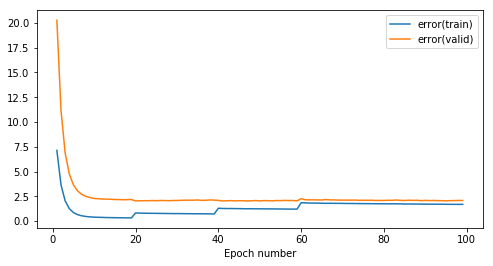

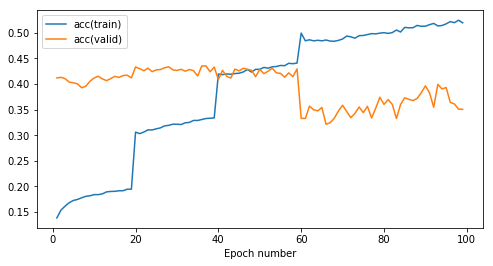

In [44]:
if jupyterNotebookEnabled:
    %%time
#1. 20 repetitions and higher lamda2 regularization

curriculum_step = 200
repetitions = 20

epochs = getMinEpochs(num_batches, curriculum_step, repetitions) + 20

stats, keys = curriculumLearning(epochs = epochs,
                                 curriculum_step=curriculum_step,
                                 repetitions=repetitions,
                                lamda2=1e-1)

if plotting:
    fig_1, ax_1, fig_2, ax_2 = plotStats(stats, keys)
    figcount += 1
    if saving:
        fig_1.savefig('cw%d_part%d_%02d_fig_error.svg' % (coursework, part, figcount))
        fig_2.savefig('cw%d_part%d_%02d_fig_valid.svg' % (coursework, part, figcount))
        saveStats(coursework, part, figcount, stats)

epochs: 32
curriculum step: 200
repetitions: 3
epochs: 32
input_keep_prob: 0.700000
hidden_keep_prob: 0.837125
End epoch 01 (4.201 secs): err(train)=2.29, acc(train)=0.10, err(valid)=8.52, acc(valid)=0.39, 
End epoch 02 (4.093 secs): err(train)=1.84, acc(train)=0.14, err(valid)=7.03, acc(valid)=0.42, 
End epoch 03 (4.185 secs): err(train)=1.50, acc(train)=0.16, err(valid)=5.87, acc(valid)=0.42, 
End epoch 04 (8.387 secs): err(train)=2.39, acc(train)=0.27, err(valid)=4.34, acc(valid)=0.43, 
End epoch 05 (8.311 secs): err(train)=1.80, acc(train)=0.29, err(valid)=3.49, acc(valid)=0.44, 
End epoch 06 (8.318 secs): err(train)=1.44, acc(train)=0.30, err(valid)=3.00, acc(valid)=0.43, 
End epoch 07 (12.308 secs): err(train)=1.92, acc(train)=0.39, err(valid)=2.56, acc(valid)=0.43, 
End epoch 08 (12.400 secs): err(train)=1.65, acc(train)=0.40, err(valid)=2.31, acc(valid)=0.43, 
End epoch 09 (12.323 secs): err(train)=1.48, acc(train)=0.41, err(valid)=2.16, acc(valid)=0.43, 
End epoch 10 (16.639 s

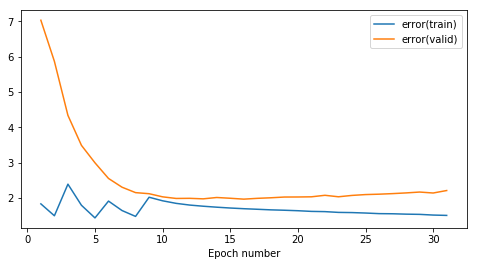

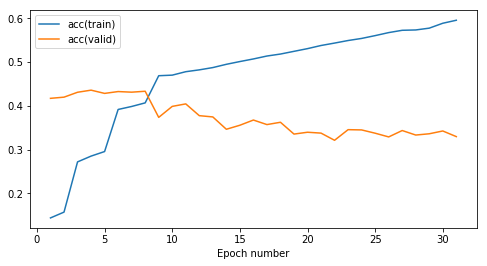

In [47]:
if jupyterNotebookEnabled:
    %%time
#2. BEST PARAMS

curriculum_step, repetitions = best_params #200, 3

epochs = getMinEpochs(num_batches, curriculum_step, repetitions) + 20

stats, keys = curriculumLearning(epochs = epochs, curriculum_step=curriculum_step, repetitions=repetitions)

if plotting:
    fig_1, ax_1, fig_2, ax_2 = plotStats(stats, keys)
    figcount += 1
    if saving:
        fig_1.savefig('cw%d_part%d_%02d_fig_error.svg' % (coursework, part, figcount))
        fig_2.savefig('cw%d_part%d_%02d_fig_valid.svg' % (coursework, part, figcount))
        saveStats(coursework, part, figcount, stats)

epochs: 100
curriculum step: 200
repetitions: 20
epochs: 100
input_keep_prob: 0.700000
hidden_keep_prob: 0.837125
End epoch 01 (4.132 secs): err(train)=2.29, acc(train)=0.10, err(valid)=8.53, acc(valid)=0.39, 
End epoch 02 (4.061 secs): err(train)=1.84, acc(train)=0.14, err(valid)=7.04, acc(valid)=0.42, 
End epoch 03 (4.050 secs): err(train)=1.50, acc(train)=0.16, err(valid)=5.88, acc(valid)=0.42, 
End epoch 04 (4.209 secs): err(train)=1.24, acc(train)=0.16, err(valid)=5.00, acc(valid)=0.42, 
End epoch 05 (4.057 secs): err(train)=1.04, acc(train)=0.17, err(valid)=4.36, acc(valid)=0.42, 
End epoch 06 (4.111 secs): err(train)=0.88, acc(train)=0.18, err(valid)=3.89, acc(valid)=0.42, 
End epoch 07 (4.049 secs): err(train)=0.77, acc(train)=0.18, err(valid)=3.53, acc(valid)=0.41, 
End epoch 08 (4.053 secs): err(train)=0.68, acc(train)=0.19, err(valid)=3.27, acc(valid)=0.41, 
End epoch 09 (4.087 secs): err(train)=0.61, acc(train)=0.19, err(valid)=3.06, acc(valid)=0.41, 
End epoch 10 (4.052 se

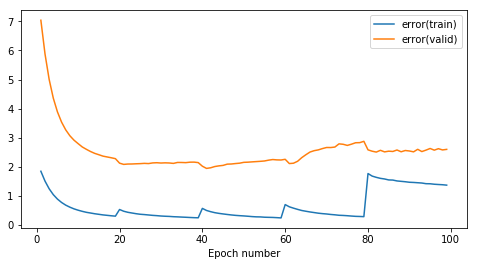

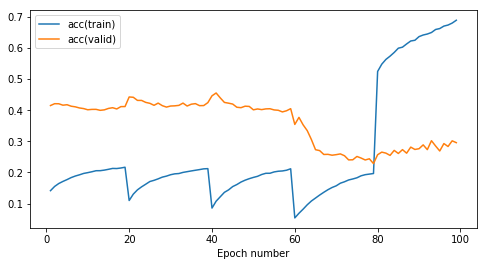

In [49]:
if jupyterNotebookEnabled:
    %%time
#3. WITHOUT REPEAT PREVIOUS CURRICULUM LEVELS (repeat_school_class=False)

curriculum_step = 200
repetitions = 20

epochs = getMinEpochs(num_batches, curriculum_step, repetitions) + 20

stats, keys = curriculumLearning(epochs = epochs, curriculum_step=curriculum_step, repetitions=repetitions,
                                    repeat_school_class=False)

if plotting:
    fig_1, ax_1, fig_2, ax_2 = plotStats(stats, keys)
    figcount += 1
    if saving:
        fig_1.savefig('cw%d_part%d_%02d_fig_error.svg' % (coursework, part, figcount))
        fig_2.savefig('cw%d_part%d_%02d_fig_valid.svg' % (coursework, part, figcount))
        saveStats(coursework, part, figcount, stats)

epochs: 100
curriculum step: 200
repetitions: 20
epochs: 100
input_keep_prob: 0.700000
hidden_keep_prob: 0.837125
End epoch 01 (4.137 secs): err(train)=2.29, acc(train)=0.10, err(valid)=8.51, acc(valid)=0.40, 
End epoch 02 (4.051 secs): err(train)=1.84, acc(train)=0.14, err(valid)=7.02, acc(valid)=0.42, 
End epoch 03 (4.049 secs): err(train)=1.50, acc(train)=0.15, err(valid)=5.85, acc(valid)=0.42, 
End epoch 04 (4.151 secs): err(train)=1.23, acc(train)=0.16, err(valid)=4.98, acc(valid)=0.42, 
End epoch 05 (4.046 secs): err(train)=1.03, acc(train)=0.17, err(valid)=4.34, acc(valid)=0.42, 
End epoch 06 (4.052 secs): err(train)=0.88, acc(train)=0.18, err(valid)=3.87, acc(valid)=0.41, 
End epoch 07 (4.052 secs): err(train)=0.76, acc(train)=0.18, err(valid)=3.52, acc(valid)=0.41, 
End epoch 08 (4.053 secs): err(train)=0.67, acc(train)=0.19, err(valid)=3.27, acc(valid)=0.41, 
End epoch 09 (4.048 secs): err(train)=0.60, acc(train)=0.19, err(valid)=3.06, acc(valid)=0.41, 
End epoch 10 (4.048 se

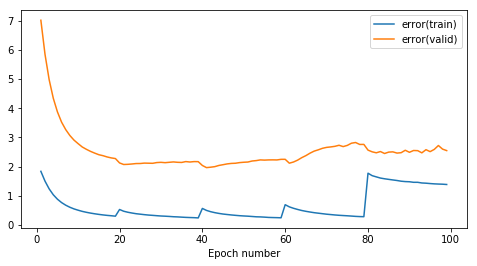

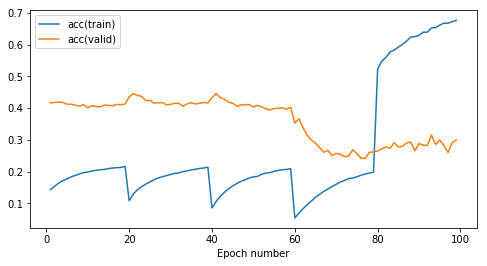

In [50]:
if jupyterNotebookEnabled:
    %%time
#4. WITHOUT REPEAT PREVIOUS CURRICULUM LEVELS (repeat_school_class=False) AND SHUFFLE = TRUE

curriculum_step = 200
repetitions = 20

epochs = getMinEpochs(num_batches, curriculum_step, repetitions) + 20

stats, keys = curriculumLearning(epochs = epochs, curriculum_step=curriculum_step, repetitions=repetitions,
                                    repeat_school_class=False, shuffle_cur_curriculum=True)

if plotting:
    fig_1, ax_1, fig_2, ax_2 = plotStats(stats, keys)
    figcount += 1
    if saving:
        fig_1.savefig('cw%d_part%d_%02d_fig_error.svg' % (coursework, part, figcount))
        fig_2.savefig('cw%d_part%d_%02d_fig_valid.svg' % (coursework, part, figcount))
        saveStats(coursework, part, figcount, stats)

epochs: 40
curriculum step: 200
repetitions: 5
epochs: 40
input_keep_prob: 0.700000
hidden_keep_prob: 0.837125
End epoch 01 (4.160 secs): err(train)=2.29, acc(train)=0.10, err(valid)=8.51, acc(valid)=0.39, 
End epoch 02 (4.100 secs): err(train)=1.84, acc(train)=0.14, err(valid)=7.03, acc(valid)=0.42, 
End epoch 03 (4.096 secs): err(train)=1.50, acc(train)=0.16, err(valid)=5.86, acc(valid)=0.42, 
End epoch 04 (4.174 secs): err(train)=1.24, acc(train)=0.16, err(valid)=4.99, acc(valid)=0.42, 
End epoch 05 (4.084 secs): err(train)=1.03, acc(train)=0.17, err(valid)=4.34, acc(valid)=0.42, 
End epoch 06 (8.196 secs): err(train)=1.79, acc(train)=0.28, err(valid)=3.48, acc(valid)=0.43, 
End epoch 07 (8.224 secs): err(train)=1.44, acc(train)=0.30, err(valid)=2.99, acc(valid)=0.43, 
End epoch 08 (8.172 secs): err(train)=1.22, acc(train)=0.31, err(valid)=2.69, acc(valid)=0.43, 
End epoch 09 (8.230 secs): err(train)=1.07, acc(train)=0.31, err(valid)=2.48, acc(valid)=0.43, 
End epoch 10 (8.185 secs)

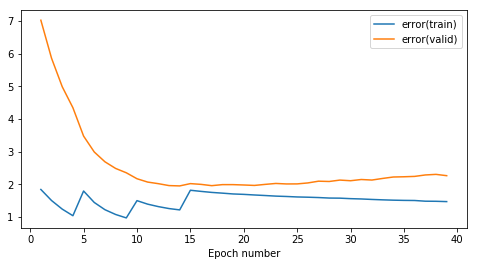

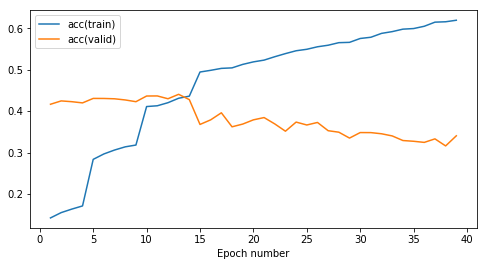

In [51]:
if jupyterNotebookEnabled:
    %%time
#5. REPEATING PREVIOUS CURRICULUM LEVELS AND SHUFFLE = TRUE

curriculum_step = 200
repetitions = 5

epochs = getMinEpochs(num_batches, curriculum_step, repetitions) + 20

stats, keys = curriculumLearning(epochs = epochs, curriculum_step=curriculum_step, repetitions=repetitions,
                                    repeat_school_class=True, shuffle_cur_curriculum=True)

if plotting:
    fig_1, ax_1, fig_2, ax_2 = plotStats(stats, keys)
    figcount += 1
    if saving:
        fig_1.savefig('cw%d_part%d_%02d_fig_error.svg' % (coursework, part, figcount))
        fig_2.savefig('cw%d_part%d_%02d_fig_valid.svg' % (coursework, part, figcount))
        saveStats(coursework, part, figcount, stats)

epochs: 180
curriculum step: 50
repetitions: 10
epochs: 180
input_keep_prob: 0.700000
hidden_keep_prob: 0.837125
End epoch 01 (1.124 secs): err(train)=0.62, acc(train)=0.02, err(valid)=9.87, acc(valid)=0.30, 
End epoch 02 (1.044 secs): err(train)=0.57, acc(train)=0.03, err(valid)=9.37, acc(valid)=0.34, 
End epoch 03 (1.043 secs): err(train)=0.53, acc(train)=0.04, err(valid)=8.89, acc(valid)=0.36, 
End epoch 04 (1.039 secs): err(train)=0.50, acc(train)=0.04, err(valid)=8.42, acc(valid)=0.37, 
End epoch 05 (1.039 secs): err(train)=0.47, acc(train)=0.05, err(valid)=7.99, acc(valid)=0.38, 
End epoch 06 (1.047 secs): err(train)=0.44, acc(train)=0.05, err(valid)=7.58, acc(valid)=0.38, 
End epoch 07 (1.037 secs): err(train)=0.42, acc(train)=0.05, err(valid)=7.20, acc(valid)=0.38, 
End epoch 08 (1.035 secs): err(train)=0.39, acc(train)=0.05, err(valid)=6.85, acc(valid)=0.38, 
End epoch 09 (1.056 secs): err(train)=0.37, acc(train)=0.05, err(valid)=6.53, acc(valid)=0.38, 
End epoch 10 (1.058 sec

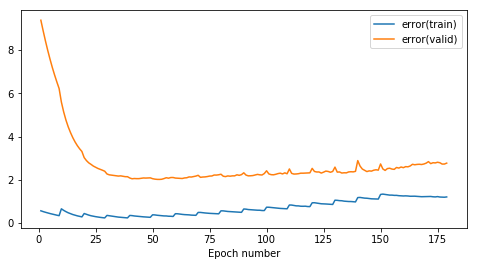

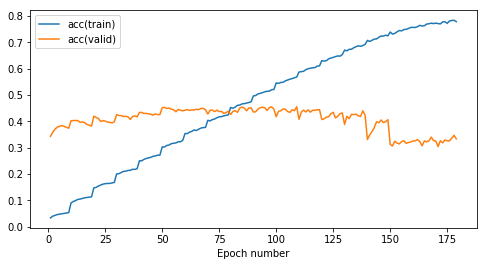

In [52]:
if jupyterNotebookEnabled:
    %%time
#6. REPEATING PREVIOUS CURRICULUM LEVELS AND SHUFFLE = TRUE but smaller curr step and larger repetitions

curriculum_step = 50
repetitions = 10

epochs = getMinEpochs(num_batches, curriculum_step, repetitions) + 20

stats, keys = curriculumLearning(epochs = epochs, curriculum_step=curriculum_step, repetitions=repetitions,
                                    repeat_school_class=True, shuffle_cur_curriculum=True)

if plotting:
    fig_1, ax_1, fig_2, ax_2 = plotStats(stats, keys)
    figcount += 1
    if saving:
        fig_1.savefig('cw%d_part%d_%02d_fig_error.svg' % (coursework, part, figcount))
        fig_2.savefig('cw%d_part%d_%02d_fig_valid.svg' % (coursework, part, figcount))
        saveStats(coursework, part, figcount, stats)

epochs: 180
curriculum step: 50
repetitions: 10
epochs: 180
input_keep_prob: 1.000000
hidden_keep_prob: 1.000000
End epoch 01 (1.287 secs): err(train)=0.61, acc(train)=0.03, err(valid)=9.74, acc(valid)=0.32, 
End epoch 02 (1.026 secs): err(train)=0.54, acc(train)=0.04, err(valid)=9.13, acc(valid)=0.35, 
End epoch 03 (1.030 secs): err(train)=0.50, acc(train)=0.05, err(valid)=8.55, acc(valid)=0.36, 
End epoch 04 (1.020 secs): err(train)=0.45, acc(train)=0.06, err(valid)=8.03, acc(valid)=0.36, 
End epoch 05 (1.027 secs): err(train)=0.41, acc(train)=0.06, err(valid)=7.54, acc(valid)=0.34, 
End epoch 06 (1.025 secs): err(train)=0.38, acc(train)=0.06, err(valid)=7.07, acc(valid)=0.33, 
End epoch 07 (1.025 secs): err(train)=0.35, acc(train)=0.06, err(valid)=6.64, acc(valid)=0.33, 
End epoch 08 (1.020 secs): err(train)=0.32, acc(train)=0.06, err(valid)=6.22, acc(valid)=0.32, 
End epoch 09 (1.027 secs): err(train)=0.29, acc(train)=0.06, err(valid)=5.84, acc(valid)=0.32, 
End epoch 10 (1.033 sec

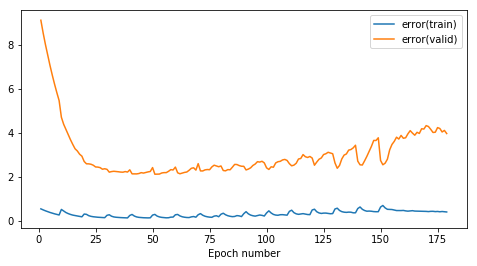

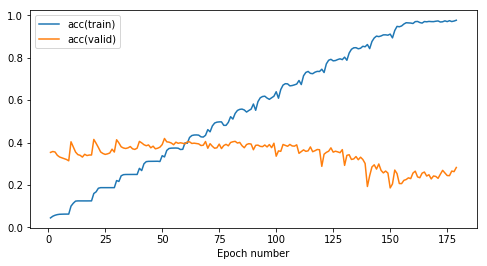

In [53]:
if jupyterNotebookEnabled:
    %%time
#7. REPEATING PREVIOUS CURRICULUM LEVELS AND SHUFFLE = TRUE but smaller curr level and larger repetitions but
# WITHOUT dropout

curriculum_step = 50
repetitions = 10

epochs = getMinEpochs(num_batches, curriculum_step, repetitions) + 20

stats, keys = curriculumLearning(epochs = epochs, curriculum_step=curriculum_step, repetitions=repetitions,
                                    repeat_school_class=True, shuffle_cur_curriculum=True,
                                keep_probabilities=[
                                    1., #input
                                    1.  #hidden
                                ])

if plotting:
    fig_1, ax_1, fig_2, ax_2 = plotStats(stats, keys)
    figcount += 1
    if saving:
        fig_1.savefig('cw%d_part%d_%02d_fig_error.svg' % (coursework, part, figcount))
        fig_2.savefig('cw%d_part%d_%02d_fig_valid.svg' % (coursework, part, figcount))
        saveStats(coursework, part, figcount, stats)

epochs: 100
curriculum step: 50
repetitions: 5
epochs: 100
input_keep_prob: 0.900000
hidden_keep_prob: 0.900000
End epoch 01 (1.089 secs): err(train)=0.66, acc(train)=0.01, err(valid)=10.05, acc(valid)=0.18, 
End epoch 02 (1.024 secs): err(train)=0.62, acc(train)=0.01, err(valid)=9.66, acc(valid)=0.20, 
End epoch 03 (1.024 secs): err(train)=0.58, acc(train)=0.02, err(valid)=9.27, acc(valid)=0.22, 
End epoch 04 (1.024 secs): err(train)=0.55, acc(train)=0.02, err(valid)=8.95, acc(valid)=0.22, 
End epoch 05 (1.026 secs): err(train)=0.52, acc(train)=0.03, err(valid)=8.65, acc(valid)=0.22, 
End epoch 06 (2.074 secs): err(train)=1.03, acc(train)=0.05, err(valid)=7.97, acc(valid)=0.28, 
End epoch 07 (2.046 secs): err(train)=0.94, acc(train)=0.05, err(valid)=7.53, acc(valid)=0.28, 
End epoch 08 (2.036 secs): err(train)=0.87, acc(train)=0.06, err(valid)=7.17, acc(valid)=0.28, 
End epoch 09 (2.052 secs): err(train)=0.80, acc(train)=0.07, err(valid)=6.86, acc(valid)=0.27, 
End epoch 10 (2.039 sec

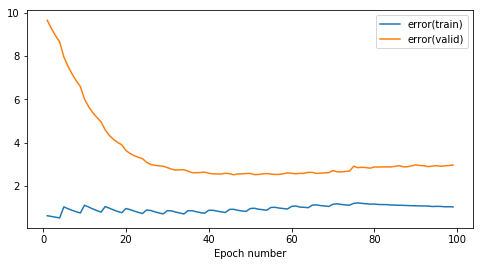

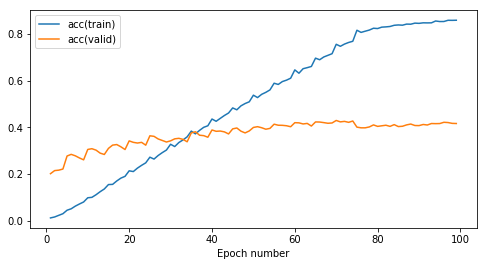

In [54]:
if jupyterNotebookEnabled:
    %%time
#8. REPEATING PREVIOUS CURRICULUM LEVELS and SHUFFLE = TRUE and WITH LITTLE DROPOUT and
# WITH REVERSE ORDER of curriculum

curriculum_step = 50
repetitions = 5

epochs = getMinEpochs(num_batches, curriculum_step, repetitions) + 20

stats, keys = curriculumLearning(epochs = epochs, curriculum_step=curriculum_step, repetitions=repetitions,
                                    repeat_school_class=True, shuffle_cur_curriculum=True,
                                keep_probabilities=[
                                    0.9, #input
                                    0.9  #hidden
                                ], reverse_order = True)

if plotting:
    fig_1, ax_1, fig_2, ax_2 = plotStats(stats, keys)
    figcount += 1
    if saving:
        fig_1.savefig('cw%d_part%d_%02d_fig_error.svg' % (coursework, part, figcount))
        fig_2.savefig('cw%d_part%d_%02d_fig_valid.svg' % (coursework, part, figcount))
        saveStats(coursework, part, figcount, stats)

curriculum step: 50
repetitions: 1
input_keep_prob: 0.800000
hidden_keep_prob: 0.800000
=====curr level: 50
End epoch 01 (1.106 secs): err(train)=0.62, acc(train)=0.02, err(valid)=9.87, acc(valid)=0.30, 
End epoch 02 (1.040 secs): err(train)=0.57, acc(train)=0.03, err(valid)=9.37, acc(valid)=0.34, 
End epoch 03 (1.077 secs): err(train)=0.54, acc(train)=0.04, err(valid)=8.88, acc(valid)=0.36, 
End epoch 04 (1.032 secs): err(train)=0.50, acc(train)=0.04, err(valid)=8.42, acc(valid)=0.37, 
End epoch 05 (1.030 secs): err(train)=0.47, acc(train)=0.05, err(valid)=7.98, acc(valid)=0.37, 
End epoch 06 (1.035 secs): err(train)=0.44, acc(train)=0.05, err(valid)=7.57, acc(valid)=0.38, 
End epoch 07 (1.040 secs): err(train)=0.42, acc(train)=0.05, err(valid)=7.19, acc(valid)=0.38, 
End epoch 08 (1.029 secs): err(train)=0.39, acc(train)=0.05, err(valid)=6.83, acc(valid)=0.38, 
End epoch 09 (1.033 secs): err(train)=0.37, acc(train)=0.05, err(valid)=6.50, acc(valid)=0.38, 
End epoch 10 (1.029 secs): e

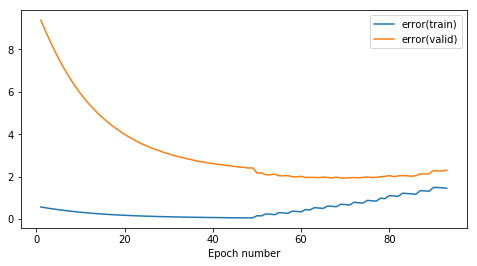

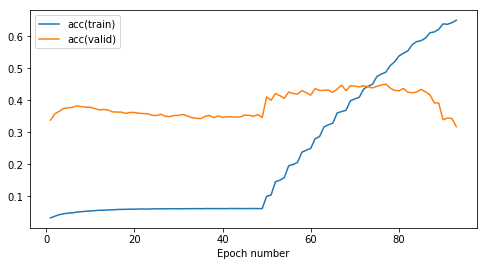

In [56]:
if jupyterNotebookEnabled:
    %%time
#9. REPEATING PREVIOUS CURRICULUM LEVELS and SHUFFLE = TRUE and WITH LITTLE DROPOUT and
# WITH NORMAL ORDER of curriculum and SELF PACED

curriculum_step = 50
repetitions = 1

epochs = getMinEpochs(num_batches, curriculum_step, repetitions) + 20

stats, keys = curriculumLearning(epochs = epochs, curriculum_step=curriculum_step, repetitions=repetitions,
                                    repeat_school_class=True, shuffle_cur_curriculum=True,
                                keep_probabilities=[
                                    0.8, #input
                                    0.8  #hidden
                                ], reverse_order = False,
                                self_paced = True)

if plotting:
    fig_1, ax_1, fig_2, ax_2 = plotStats(stats, keys)
    figcount += 1
    if saving:
        fig_1.savefig('cw%d_part%d_%02d_fig_error.svg' % (coursework, part, figcount))
        fig_2.savefig('cw%d_part%d_%02d_fig_valid.svg' % (coursework, part, figcount))
        saveStats(coursework, part, figcount, stats)

curriculum step: 50
repetitions: 1
input_keep_prob: 0.800000
hidden_keep_prob: 0.800000
=====curr level: 50
End epoch 01 (1.100 secs): err(train)=0.67, acc(train)=0.01, err(valid)=10.10, acc(valid)=0.18, 
End epoch 02 (1.024 secs): err(train)=0.63, acc(train)=0.01, err(valid)=9.74, acc(valid)=0.20, 
End epoch 03 (1.023 secs): err(train)=0.60, acc(train)=0.01, err(valid)=9.41, acc(valid)=0.22, 
End epoch 04 (1.026 secs): err(train)=0.58, acc(train)=0.01, err(valid)=9.09, acc(valid)=0.22, 
End epoch 05 (1.025 secs): err(train)=0.55, acc(train)=0.02, err(valid)=8.78, acc(valid)=0.22, 
End epoch 06 (1.027 secs): err(train)=0.53, acc(train)=0.02, err(valid)=8.52, acc(valid)=0.22, 
End epoch 07 (1.027 secs): err(train)=0.51, acc(train)=0.02, err(valid)=8.28, acc(valid)=0.22, 
End epoch 08 (1.022 secs): err(train)=0.48, acc(train)=0.03, err(valid)=8.08, acc(valid)=0.21, 
End epoch 09 (1.033 secs): err(train)=0.47, acc(train)=0.03, err(valid)=7.89, acc(valid)=0.21, 
End epoch 10 (1.019 secs): 

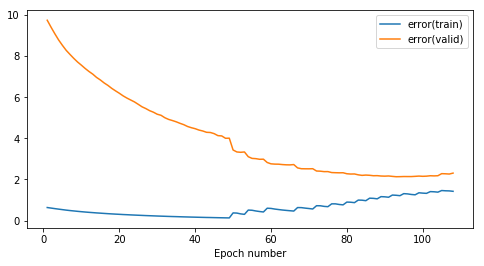

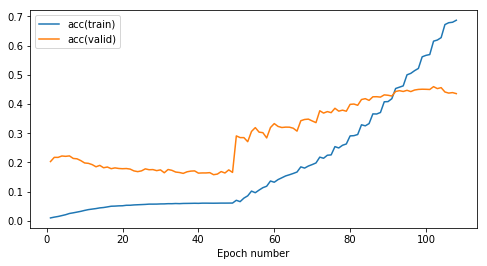

In [55]:
if jupyterNotebookEnabled:
    %%time
#10. REPEATING PREVIOUS CURRICULUM LEVELS and SHUFFLE = TRUE and WITH LITTLE DROPOUT and
# WITH REVERSE ORDER of curriculum and SELF PACED

curriculum_step = 50
repetitions = 1

epochs = getMinEpochs(num_batches, curriculum_step, repetitions) + 20

stats, keys = curriculumLearning(epochs = epochs, curriculum_step=curriculum_step, repetitions=repetitions,
                                    repeat_school_class=True, shuffle_cur_curriculum=True,
                                keep_probabilities=[
                                    0.8, #input
                                    0.8  #hidden
                                ], reverse_order = True,
                                self_paced = True)

if plotting:
    fig_1, ax_1, fig_2, ax_2 = plotStats(stats, keys)
    figcount += 1
    if saving:
        fig_1.savefig('cw%d_part%d_%02d_fig_error.svg' % (coursework, part, figcount))
        fig_2.savefig('cw%d_part%d_%02d_fig_valid.svg' % (coursework, part, figcount))
        saveStats(coursework, part, figcount, stats)

curriculum step: 5
repetitions: 1
input_keep_prob: 0.700000
hidden_keep_prob: 0.837125
=====curr level: 5
End epoch 01 (0.170 secs): err(train)=0.07, acc(train)=0.00, err(valid)=10.45, acc(valid)=0.13, 
End epoch 02 (0.103 secs): err(train)=0.07, acc(train)=0.00, err(valid)=10.43, acc(valid)=0.13, 
End epoch 03 (0.103 secs): err(train)=0.07, acc(train)=0.00, err(valid)=10.41, acc(valid)=0.13, 
End epoch 04 (0.103 secs): err(train)=0.06, acc(train)=0.00, err(valid)=10.40, acc(valid)=0.14, 
End epoch 05 (0.103 secs): err(train)=0.06, acc(train)=0.00, err(valid)=10.39, acc(valid)=0.14, 
End epoch 06 (0.103 secs): err(train)=0.06, acc(train)=0.00, err(valid)=10.38, acc(valid)=0.14, 
End epoch 07 (0.105 secs): err(train)=0.06, acc(train)=0.00, err(valid)=10.38, acc(valid)=0.14, 
End epoch 08 (0.101 secs): err(train)=0.06, acc(train)=0.00, err(valid)=10.37, acc(valid)=0.14, 
End epoch 09 (0.105 secs): err(train)=0.06, acc(train)=0.00, err(valid)=10.37, acc(valid)=0.13, 
End epoch 10 (0.103 s

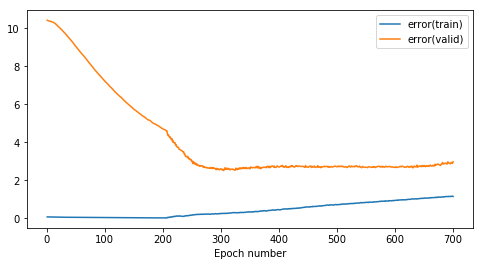

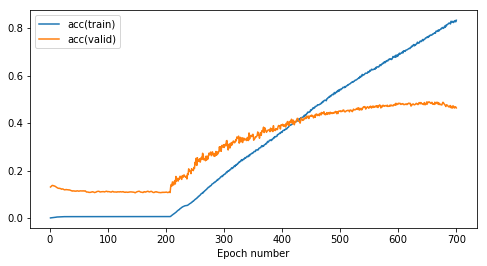

In [57]:
if jupyterNotebookEnabled:
    %%time
#11. REPEATING PREVIOUS CURRICULUM LEVELS and SHUFFLE = TRUE and WITH LITTLE DROPOUT and
# WITH REVERSE ORDER of curriculum and SELF PACED

curriculum_step = 5
repetitions = 1

epochs = 0

stats, keys = curriculumLearning(epochs = epochs, curriculum_step=curriculum_step, repetitions=repetitions,
                                    repeat_school_class=True, shuffle_cur_curriculum=True,
                                
                                 keep_probabilities=best_probs_base_classifier,
                                
                                 reverse_order = True,
                                self_paced = True)

if plotting:
    fig_1, ax_1, fig_2, ax_2 = plotStats(stats, keys)
    figcount += 1
    if saving:
        fig_1.savefig('cw%d_part%d_%02d_fig_error.svg' % (coursework, part, figcount))
        fig_2.savefig('cw%d_part%d_%02d_fig_valid.svg' % (coursework, part, figcount))
        saveStats(coursework, part, figcount, stats)